# Gas storage analysis

In this example we will analize the costs and the possible gain of natural gas trading.

We have access to monthly historical data of natural gas prices in `Nat_Gas.csv`.

We use the `Storage` class to keep track of the costs.

## Price prediction model
We have access to monthly data but I would like to have daily data. We can then perform a regression to obtain the curve that fits the monthly data. The same function can be used to estimate future prices.

From a first analysis we see that the behavior of the prices is periodic, with a postive overall trend.
We recall that any periodi function can be approximated by its Fourier series
$$
    f(x) = a_0 + \sum_{n=1}^{\infty}(a_n \cos(nx) + b_n \sin(nx))
$$

Therefore we can perform a linear regression to estimate the $a_0$, $a_n$ and $b_n$ coefficients.

In [72]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

T = 365
K = 4

def build_model(df):

    df['Dates'] = pd.to_datetime(df['Dates'])
    df['t'] = (df['Dates'] - pd.Timestamp("10/31/20")) / pd.Timedelta(days=1)

    for k in range(1, K + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['t'] / T)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['t'] / T)
    

    features = ['t'] + [f'sin_{k}' for k in range(1, K+1)] + [f'cos_{k}' for k in range(1, K+1)]
    X = df[features]
    y = df['Prices']

    return LinearRegression().fit(X, y)


def price_prediction(date, model):
    df = pd.DataFrame({"t": [(pd.Timestamp(date) - pd.Timestamp("10/31/20")) / pd.Timedelta(days=1)]})

    for k in range(1, K + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['t'] / T)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['t'] / T)

    features = ['t'] + [f'sin_{k}' for k in range(1, K+1)] + [f'cos_{k}' for k in range(1, K+1)]
    X = df[features]
 
    return float(model.predict(X)[0])

In [73]:
from functools import partial

df = pd.read_csv("Nat_Gas.csv")
df['Dates'] = pd.to_datetime(df['Dates'])

model = build_model(df)


/var/folders/_9/mfz5m43n17dgv63005blx2nw0000gn/T/ipykernel_14861/2391689528.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


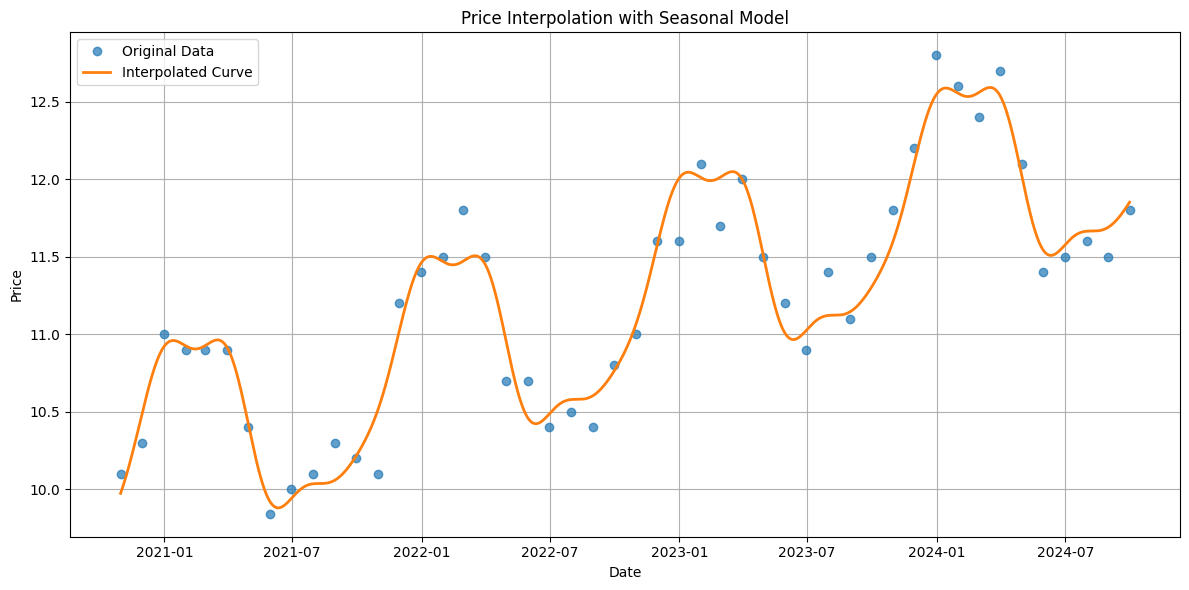

In [74]:
import matplotlib.pyplot as plt

date_range = pd.date_range(start=df['Dates'].min(), end=df['Dates'].max(), freq='D')
predicted_prices = [price_prediction(date, model) for date in date_range]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'], 'o', label='Original Data', alpha=0.7)
plt.plot(date_range, predicted_prices, '-', label='Interpolated Curve', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Interpolation with Seasonal Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
from storage import Storage

storage = Storage(max_vol = 1000000,
                  rate = 100000,
                  inj_cost = 0.1,
                  wit_cost = 0.1,
                  cost_per_day_per_unit = 0.001,
                  )

In [76]:
storage.prediction_on(partial(price_prediction, model = model))

inj_dates = ["12/15/20", "1/15/21", "2/15/21"]
wit_dates = ["1/14/21", "2/14/21", "3/14/22"]
inj_vols = [100000,50000,50000]
wit_vols = [50000,50000,100000]

storage.process(inj_dates, wit_dates, inj_vols, wit_vols)

/Users/luigi23997/Desktop/DataScience/JPM/storage/storage.py:87: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  inj['date'] = pd.to_datetime(inj['date'])
/Users/luigi23997/Desktop/DataScience/JPM/storage/storage.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wit['date'] = pd.to_datetime(wit['date'])


In [77]:
storage.cost_overview()

Costs due to injections: 20000.0
Costs due to withdrawals: 20000.0
Storage cost: 45300.00000000001
Total day of storage: 454
Total cost: 85300.0
Average cost per day: 187.88546255506608
Avarage volume stored: 99779.73568281939


In [78]:
storage.gross_gain()

Gross gain: 76478.13287787721


In [79]:
storage.net_gain()

Gross gain: 76478.13287787721
Total costs: 40099.779735682816
Net Gain: 36378.3531421944
